In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import random
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

import csv
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
from tqdm import tqdm


SAMPLE_RATE = 16000 
DURATION = 1.0  
BATCH_SIZE = 64

EPOCHS = 50

warnings.filterwarnings('ignore')


device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Cihaz: {device}")


Cihaz: cuda


In [3]:
# Ben kaggle üzerinden indirdim.Dosya yolunu data\SpeechCommands\speech_commands_v0.02 olarak ayarladım.
# Veri setini test ve train olarak ayırma işlemi torchaudio tarafından otomatik yapılıyor.
train_dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./data",url="speech_commands_v0.02", download=False, subset="training")
test_dataset = torchaudio.datasets.SPEECHCOMMANDS(root="./data", url="speech_commands_v0.02", download=False ,subset="testing")


In [4]:
labels = sorted(list(set(
    train_dataset.get_metadata(i)[2] for i in range(len(train_dataset))
)))

label_to_index = {label: i for i, label in enumerate(labels)}
index_to_label = {i: label for i, label in enumerate(labels)}
NUM_CLASSES = len(labels)

print(f"Etiketler: {labels}")
print(f"Etiket sayısı: {NUM_CLASSES}")


Etiketler: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']
Etiket sayısı: 35


In [5]:
# Pytorch DataLoader için custom collate_fn fonksiyonu
# Pytorch DataLoader, farklı uzunluktaki ses dalga formlarını tek bir batch'te birleştiremez
# Bu nedenle özel bir collate_fn fonksiyonu tanımlıyoruz
# Uzun olan kısımları keser, eksi olan kısımları ise sıfır ile doldurur
# Bu sayede modelimize sabit boyutta giriş sağlanır

def collate_fn(batch):
    waveforms , targets = [] , []
    for waveform, _, label, _, _ in batch:
        target_len = int(SAMPLE_RATE * DURATION)
        if waveform.shape[1] > target_len:
            waveform = waveform[:, :target_len]
        elif waveform.shape[1] < target_len:
            padding_needed = target_len - waveform.shape[1]
            padding = torch.zeros((1, padding_needed))
            waveform = torch.cat([waveform, padding], dim=1)
        waveforms.append(waveform)
        targets.append(label_to_index[label])
    waveforms = torch.stack(waveforms).to(device)
    targets = torch.tensor(targets, dtype=torch.long).to(device)
    return waveforms, targets

In [10]:
# CNN Modeli

class Cnn(nn.Module):
    def __init__(self,num_classes):
        super(Cnn, self).__init__()

        #n_mels 64 , 128 test edildi
        #hop_length 512, 256 test edildi
        
        self.mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=16000,
            n_mels=64,
            n_fft=1024,
            hop_length=256
        ).to(device)

        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB().to(device)
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.3) 
    
    def forward(self, x):
        x = self.mel_spectrogram(x)
        x = self.amplitude_to_db(x)

        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        
        x = self.gap(x) 
        x = torch.flatten(x, 1)

        x = self.dropout(x)

        x = self.fc1(x)
        
        return x

In [12]:
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total_samples = 0



    for data,target in tqdm(train_loader,desc="Training"):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == target).sum().item()
        total_samples += len(data)

    avg_loss = total_loss / len(train_loader) 
    acc = 100.0 * correct / total_samples
    return avg_loss, acc

    
def validate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data,target in tqdm(val_loader,desc="Validating"):
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == target).sum().item()
            total_samples += len(data)

    avg_loss = total_loss / len(val_loader)
    acc= 100.0 * correct / total_samples
    
    return avg_loss,acc
    


In [11]:
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len

train_subset, val_subset = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

model = Cnn(NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


metrics= {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

In [13]:

best_model_acc = 0.0

    
for epoch in range(EPOCHS):


    train_loss, train_acc = train_model(model, train_loader,criterion,optimizer)

    val_loss, val_acc = validate_model(model, val_loader, criterion)

    metrics["epoch"].append(epoch + 1)
    metrics["train_loss"].append(train_loss)
    metrics["train_acc"].append(train_acc)
    metrics["val_loss"].append(val_loss)
    metrics["val_acc"].append(val_acc)

    learning_rate = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{EPOCHS},Train Loss: {train_loss:.4f},Train Accuracy: {train_acc:.4f},Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


    df = pd.DataFrame(metrics)
    df.to_csv("model_metrics.csv", index=False)
    
    if val_acc > best_model_acc:
        best_model_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

        



Validating: 100%|██████████| 266/266 [00:09<00:00, 27.41it/s]


Epoch 1/50,Train Loss: 2.9966,Train Accuracy: 17.9067,Validation Loss: 2.5839, Validation Accuracy: 27.1024


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.47it/s]


Epoch 2/50,Train Loss: 2.2890,Train Accuracy: 34.9442,Validation Loss: 1.9861, Validation Accuracy: 45.1942


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.98it/s]


Epoch 3/50,Train Loss: 1.9118,Train Accuracy: 44.7786,Validation Loss: 1.5736, Validation Accuracy: 57.3811


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.75it/s]


Epoch 4/50,Train Loss: 1.6678,Train Accuracy: 51.5278,Validation Loss: 1.3982, Validation Accuracy: 61.2116


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.61it/s]


Epoch 5/50,Train Loss: 1.5023,Train Accuracy: 56.4251,Validation Loss: 1.1991, Validation Accuracy: 67.2167


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.63it/s]


Epoch 6/50,Train Loss: 1.3786,Train Accuracy: 59.8197,Validation Loss: 1.1175, Validation Accuracy: 69.5150


Validating: 100%|██████████| 266/266 [00:09<00:00, 29.04it/s]


Epoch 7/50,Train Loss: 1.2837,Train Accuracy: 62.6219,Validation Loss: 1.0156, Validation Accuracy: 72.7267


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.55it/s]


Epoch 8/50,Train Loss: 1.2057,Train Accuracy: 64.8024,Validation Loss: 0.9214, Validation Accuracy: 75.9031


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.75it/s]


Epoch 9/50,Train Loss: 1.1501,Train Accuracy: 66.6279,Validation Loss: 0.9145, Validation Accuracy: 75.5790


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.84it/s]


Epoch 10/50,Train Loss: 1.0912,Train Accuracy: 68.2691,Validation Loss: 0.8371, Validation Accuracy: 77.1819


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.90it/s]


Epoch 11/50,Train Loss: 1.0508,Train Accuracy: 69.6010,Validation Loss: 0.8337, Validation Accuracy: 77.2762


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.74it/s]


Epoch 12/50,Train Loss: 1.0167,Train Accuracy: 70.3259,Validation Loss: 0.7946, Validation Accuracy: 78.6788


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.81it/s]


Epoch 13/50,Train Loss: 0.9849,Train Accuracy: 71.1878,Validation Loss: 0.7357, Validation Accuracy: 80.4703


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.52it/s]


Epoch 14/50,Train Loss: 0.9497,Train Accuracy: 72.3370,Validation Loss: 0.7686, Validation Accuracy: 79.4743


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.53it/s]


Epoch 15/50,Train Loss: 0.9215,Train Accuracy: 73.1281,Validation Loss: 0.7166, Validation Accuracy: 80.0578


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.67it/s]


Epoch 16/50,Train Loss: 0.9051,Train Accuracy: 73.7455,Validation Loss: 0.6986, Validation Accuracy: 81.0537


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.22it/s]


Epoch 17/50,Train Loss: 0.8821,Train Accuracy: 74.2435,Validation Loss: 0.6923, Validation Accuracy: 80.4585


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.67it/s]


Epoch 18/50,Train Loss: 0.8610,Train Accuracy: 74.8976,Validation Loss: 0.6461, Validation Accuracy: 81.8434


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.79it/s]


Epoch 19/50,Train Loss: 0.8510,Train Accuracy: 75.2438,Validation Loss: 0.6137, Validation Accuracy: 83.2872


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.59it/s]


Epoch 20/50,Train Loss: 0.8263,Train Accuracy: 76.0041,Validation Loss: 0.6333, Validation Accuracy: 82.7686


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.79it/s]


Epoch 21/50,Train Loss: 0.8165,Train Accuracy: 76.1558,Validation Loss: 0.6142, Validation Accuracy: 83.4640


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.74it/s]


Epoch 22/50,Train Loss: 0.7975,Train Accuracy: 76.8866,Validation Loss: 0.6156, Validation Accuracy: 83.6643


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.49it/s]


Epoch 23/50,Train Loss: 0.7869,Train Accuracy: 77.0796,Validation Loss: 0.5900, Validation Accuracy: 84.1358


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.60it/s]


Epoch 24/50,Train Loss: 0.7724,Train Accuracy: 77.5820,Validation Loss: 0.5663, Validation Accuracy: 84.6956


Validating: 100%|██████████| 266/266 [00:09<00:00, 28.82it/s]


Epoch 25/50,Train Loss: 0.7616,Train Accuracy: 77.7278,Validation Loss: 0.5569, Validation Accuracy: 84.6779


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.11it/s]


Epoch 26/50,Train Loss: 0.7521,Train Accuracy: 77.9960,Validation Loss: 0.5515, Validation Accuracy: 84.8665


Validating: 100%|██████████| 266/266 [00:09<00:00, 26.86it/s]


Epoch 27/50,Train Loss: 0.7412,Train Accuracy: 78.3805,Validation Loss: 0.5362, Validation Accuracy: 85.7269


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.56it/s]


Epoch 28/50,Train Loss: 0.7276,Train Accuracy: 78.8019,Validation Loss: 0.5324, Validation Accuracy: 85.6149


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.33it/s]


Epoch 29/50,Train Loss: 0.7227,Train Accuracy: 79.0199,Validation Loss: 0.5314, Validation Accuracy: 85.5678


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.71it/s]


Epoch 30/50,Train Loss: 0.7100,Train Accuracy: 79.2380,Validation Loss: 0.5285, Validation Accuracy: 85.7682


Validating: 100%|██████████| 266/266 [00:10<00:00, 24.96it/s]


Epoch 31/50,Train Loss: 0.7052,Train Accuracy: 79.5268,Validation Loss: 0.5023, Validation Accuracy: 86.4753


Validating: 100%|██████████| 266/266 [00:10<00:00, 26.37it/s]


Epoch 32/50,Train Loss: 0.6983,Train Accuracy: 79.6373,Validation Loss: 0.5133, Validation Accuracy: 86.4518


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.81it/s]


Epoch 33/50,Train Loss: 0.6918,Train Accuracy: 79.8583,Validation Loss: 0.5039, Validation Accuracy: 86.4282


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.82it/s]


Epoch 34/50,Train Loss: 0.6775,Train Accuracy: 80.3592,Validation Loss: 0.4999, Validation Accuracy: 86.4518


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.69it/s]


Epoch 35/50,Train Loss: 0.6756,Train Accuracy: 80.2045,Validation Loss: 0.5026, Validation Accuracy: 86.6168


Validating: 100%|██████████| 266/266 [00:04<00:00, 61.05it/s]


Epoch 36/50,Train Loss: 0.6712,Train Accuracy: 80.3887,Validation Loss: 0.5207, Validation Accuracy: 85.8625


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.53it/s]


Epoch 37/50,Train Loss: 0.6630,Train Accuracy: 80.4918,Validation Loss: 0.5123, Validation Accuracy: 86.5755


Validating: 100%|██████████| 266/266 [00:10<00:00, 26.03it/s]


Epoch 38/50,Train Loss: 0.6582,Train Accuracy: 80.6568,Validation Loss: 0.4820, Validation Accuracy: 86.9645


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.29it/s]


Epoch 39/50,Train Loss: 0.6477,Train Accuracy: 80.9353,Validation Loss: 0.4906, Validation Accuracy: 86.7700


Validating: 100%|██████████| 266/266 [00:09<00:00, 27.64it/s]


Epoch 40/50,Train Loss: 0.6468,Train Accuracy: 81.0575,Validation Loss: 0.4664, Validation Accuracy: 87.1236


Validating: 100%|██████████| 266/266 [00:04<00:00, 59.75it/s]


Epoch 41/50,Train Loss: 0.6397,Train Accuracy: 81.3655,Validation Loss: 0.4568, Validation Accuracy: 87.8543


Validating: 100%|██████████| 266/266 [00:04<00:00, 60.35it/s]


Epoch 42/50,Train Loss: 0.6347,Train Accuracy: 81.4126,Validation Loss: 0.4788, Validation Accuracy: 86.7641


Validating: 100%|██████████| 266/266 [00:04<00:00, 58.23it/s]


Epoch 43/50,Train Loss: 0.6276,Train Accuracy: 81.7471,Validation Loss: 0.4859, Validation Accuracy: 86.5107


Validating: 100%|██████████| 266/266 [00:04<00:00, 61.25it/s]


Epoch 44/50,Train Loss: 0.6263,Train Accuracy: 81.5791,Validation Loss: 0.4717, Validation Accuracy: 87.1707


Validating: 100%|██████████| 266/266 [00:04<00:00, 60.40it/s]


Epoch 45/50,Train Loss: 0.6208,Train Accuracy: 81.7146,Validation Loss: 0.4569, Validation Accuracy: 87.4772


Validating: 100%|██████████| 266/266 [00:04<00:00, 59.59it/s]


Epoch 46/50,Train Loss: 0.6144,Train Accuracy: 81.9548,Validation Loss: 0.4619, Validation Accuracy: 87.1177


Validating: 100%|██████████| 266/266 [00:04<00:00, 59.98it/s]


Epoch 47/50,Train Loss: 0.6090,Train Accuracy: 82.2067,Validation Loss: 0.4434, Validation Accuracy: 87.5184


Validating: 100%|██████████| 266/266 [00:04<00:00, 58.54it/s]


Epoch 48/50,Train Loss: 0.6052,Train Accuracy: 82.1743,Validation Loss: 0.4370, Validation Accuracy: 87.7718


Validating: 100%|██████████| 266/266 [00:04<00:00, 58.47it/s]


Epoch 49/50,Train Loss: 0.5995,Train Accuracy: 82.3349,Validation Loss: 0.4547, Validation Accuracy: 87.7247


Validating: 100%|██████████| 266/266 [00:04<00:00, 57.06it/s]

Epoch 50/50,Train Loss: 0.5999,Train Accuracy: 82.2892,Validation Loss: 0.4456, Validation Accuracy: 87.7777


In [14]:

def test(model,test_loader,criterion):
    model.eval()
    
    running_loss = 0.0
    correct = 0
    total = 0

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_loss = running_loss / total
    test_acc = correct / total

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1:.4f}")

    try:
        all_labels = list(range(len(class_names)))
        report = classification_report(y_true, y_pred, target_names=class_names, labels=all_labels, zero_division=0)

        with open("test_report.txt", "w") as f:
            f.write(report)

    except Exception as e:
        print("Hata:", e)


class_names = [index_to_label[i] for i in range(NUM_CLASSES)]

model= Cnn(NUM_CLASSES).to(device)
model.load_state_dict(torch.load("best_model.pth"))

criterion = nn.CrossEntropyLoss()

test(model, test_loader, criterion)


100%|██████████| 172/172 [00:04<00:00, 41.44it/s]

Test Loss: 0.4749, Test Accuracy: 0.8708
Test Precision: 0.8729, Test Recall: 0.8708, Test F1 Score: 0.8704


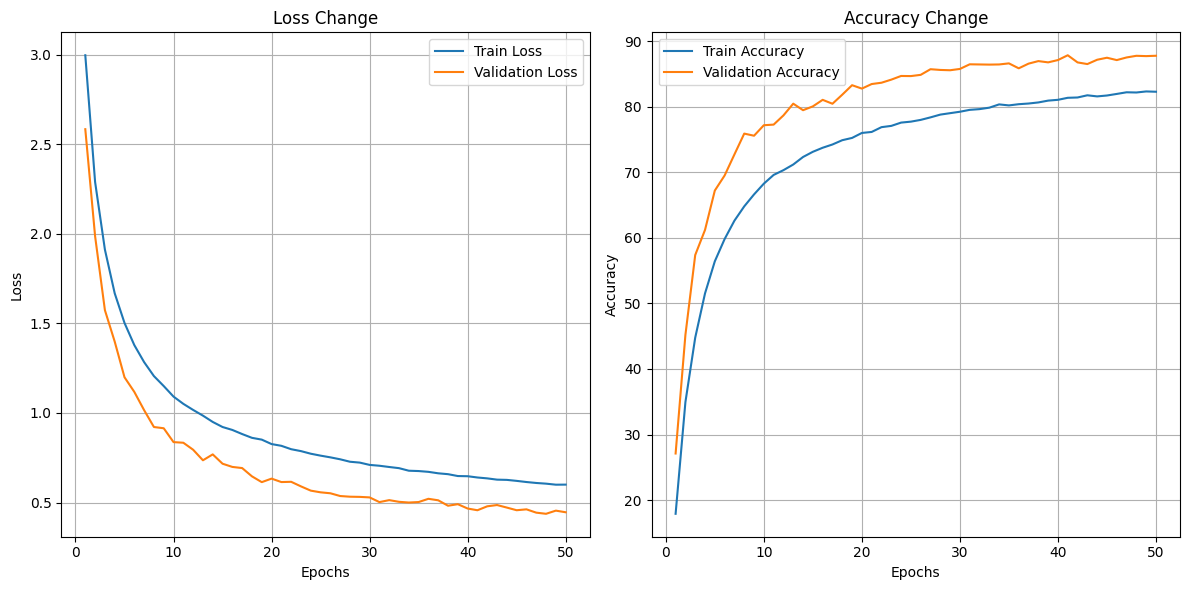

In [15]:
df = pd.read_csv("model_metrics.csv")

plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Change')
plt.legend()
plt.grid(True)



plt.subplot(1,2,2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy')
plt.plot(df['epoch'], df['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Change')
plt.legend()
plt.grid(True)
    

plt.tight_layout()

plt.show()
    